# Calculating Median Pressures of Raman CO2 calibration analyses from ESI-TEC software log 
- This workbook shows how to extract and calculate median+standard deviation of pressure log data from the ESI-TEC software files corresponding to calibration analyses.
- This data is from Devitre et al. (2021), collected from acqusitions on a high pressure optical cell on the Cornell WITec Alpha300R. 

In [1]:
# Import useful python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
from docx import Document
import datetime

## Downloading DiadFit locally
- The easiest way to install diad fit is by removing the #. It will install from PyPI
- You only need to do this once on each computer, or run in order to grab an updated version. 

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [2]:
import DiadFit as pf
pf.__version__

'0.0.44'

## Extracting information from the ESI-TEC report files (.docx)
- ESI-Tec software exports a report in word document format, in which the absolute start time of the analysis,serial number of the sensor and other information are stored that we need to access

### First, we identify the report files

In [3]:
path=os.getcwd()
filetype_reports=['.docx']

report_files=pf.Psensor.get_files(path=path,filetype=filetype_reports)
display(report_files)

['08272021_CALIBRATION.docx']

### The, we strip the start time of the analysis and the serial number of the sensor from the file

In [4]:
j=0
rep=report_files[j]

start_time,sn_str=pf.Psensor.report_info(path=path,report=rep)

2021-08-27 14:16:15
Serial No. 0830903


## Extracting pressure data from the ESI-TEC pressure log
- ESI-TEC software exports the full pressure log to either excel or csv, which we extract here

### First, we identify the data files 
- These could be excel or csv, we can load either

In [5]:
filetype=['.csv','.xlsx']

pfiles=pf.Psensor.get_files(path=path,filetype=filetype)
display(pfiles)

['merged_dataframe.xlsx',
 'PRESSURE SENSOR OUT 08272021.xlsx',
 'RAMANCALIB_0826272021_Calibration_fitting.xlsx']

### Now pick a file to start with and read in the data
- Here we will obtain a Date and Time column based on the report start time and a Timestamp column (UNIX time)

In [6]:
i=1 # select filenumber in pfiles
print(pfiles[i])

pdata=pf.Psensor.read_pfiles(path=path,file=pfiles[i],start_time=start_time,sn_name=sn_str)
display(pdata.head())

PRESSURE SENSOR OUT 08272021.xlsx


,Time_sincestart,Pressure / MPa,Temperature / °C,Date and Time,unix_timestamp
0,00:00:00.000000,0.102049,23.197266,2021-08-27 14:16:15.000000,1.630074e+09
1,00:00:00.999720,0.101389,23.195312,2021-08-27 14:16:15.999720,1.630074e+09
2,00:00:01.999435,0.102284,23.195312,2021-08-27 14:16:16.999435,1.630074e+09
3,00:00:03.001299,0.101436,23.195312,2021-08-27 14:16:18.001299,1.630074e+09
4,00:00:04.000269,0.102331,23.195312,2021-08-27 14:16:19.000269,1.630074e+09


### We can plot the pressure data with Date and Time 

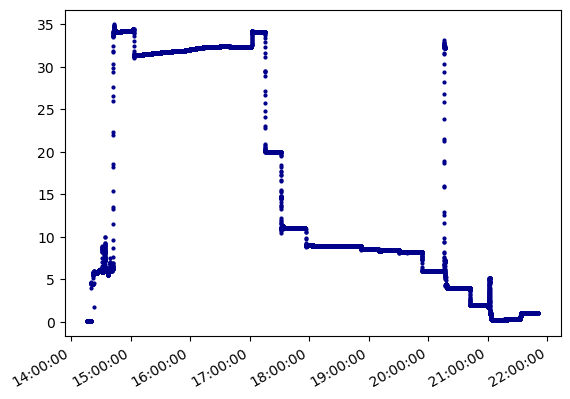

In [15]:
plt.plot_date(pdata['Date and Time'],pdata['Pressure / MPa'],'o',markersize=2,color='darkblue',zorder=0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

## Now read in the calibration analysis data 
- This is output xlsx by "Stitch_Outputs_Together.pynb" using DiadFit. 
- You could also simply use a metadata table, but it must have the correct format as output by DiadFit metadata loop functions.

In [8]:
sdata_base = pd.read_excel(pfiles[2])
sdata_base=sdata_base.drop(columns={'Unnamed: 0'}) # drop unnamed column
display(sdata_base.head())

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,Ne_Correction
0,FDCA33,102.740665,102.696858,1285.885695,131.244854,1285.885695,142.948120,0.513379,4.585509,2.138618e-09,...,27,NaN,45,5,5,"['0h', '3m', '47s']",9:13:50 PM\n,76430,1325,1.000427
1,FDCA34,102.723802,102.680015,1285.902039,105.631707,1285.902039,127.804212,0.567454,1.967848,6.360690e-12,...,27,NaN,45,5,5,"['0h', '3m', '47s']",9:20:59 PM\n,76859,1325,1.000426
2,FDCA35,102.692651,102.648897,1285.903198,75.000553,1285.903198,96.602081,0.602837,1.995069,6.134671e-11,...,27,NaN,45,5,5,"['0h', '3m', '47s']",9:31:48 PM\n,77508,1325,1.000426
3,FDCA36,104.523013,104.478491,1285.839065,208.917640,1285.839065,261.922786,0.597838,4.648317,2.899832e-07,...,27,NaN,45,3,5,"['0h', '2m', '17s']",9:38:52 PM\n,77932,1325,1.000426
4,FDCA37,102.777657,102.733889,1285.800093,222.160979,1285.800093,266.930085,0.553759,3.206777,5.426918e-02,...,27,NaN,45,3,5,"['0h', '2m', '17s']",9:44:16 PM\n,78256,1325,1.000426


# Calculate the datetime, unix timestamp and duration of each analysis
- Here we can specify a time offset between the raman computer and the pressure recording computer
- For this dataset, the raman computer was about ~4 minutes ahead of the pressure recording computer. If we specify df=sdata,raman_cpu_offset='ahead',offset_hms=[0,5,0] as arguments of the function, we will immediately at the end that the standard deviations of the pressure medians are much lower. If instead we said raman_cpu_offset='none', we can see at the end that the standard deviations are large for some samples.

In [11]:
sdata=pf.Psensor.add_datetime_and_duration_cols(df=sdata_base,raman_cpu_offset='ahead',offset_hms=[0,4,0])
sdata.head()

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,Ne_Correction,Date and Time,Date and Time - offset,unix_timestamp,duration_s
0,FDCA33,102.740665,102.696858,1285.885695,131.244854,1285.885695,142.948120,0.513379,4.585509,2.138618e-09,...,5,"['0h', '3m', '47s']",9:13:50 PM,76430,1325,1.000427,2021-08-27 21:13:50,2021-08-27 21:09:50,1.630099e+09,227.0
1,FDCA34,102.723802,102.680015,1285.902039,105.631707,1285.902039,127.804212,0.567454,1.967848,6.360690e-12,...,5,"['0h', '3m', '47s']",9:20:59 PM,76859,1325,1.000426,2021-08-27 21:20:59,2021-08-27 21:16:59,1.630099e+09,227.0
2,FDCA35,102.692651,102.648897,1285.903198,75.000553,1285.903198,96.602081,0.602837,1.995069,6.134671e-11,...,5,"['0h', '3m', '47s']",9:31:48 PM,77508,1325,1.000426,2021-08-27 21:31:48,2021-08-27 21:27:48,1.630100e+09,227.0
3,FDCA36,104.523013,104.478491,1285.839065,208.917640,1285.839065,261.922786,0.597838,4.648317,2.899832e-07,...,5,"['0h', '2m', '17s']",9:38:52 PM,77932,1325,1.000426,2021-08-27 21:38:52,2021-08-27 21:34:52,1.630100e+09,137.0
4,FDCA37,102.777657,102.733889,1285.800093,222.160979,1285.800093,266.930085,0.553759,3.206777,5.426918e-02,...,5,"['0h', '2m', '17s']",9:44:16 PM,78256,1325,1.000426,2021-08-27 21:44:16,2021-08-27 21:40:16,1.630100e+09,137.0


# Calculate the median pressure and median absolute deviation for each analysis
- This portion calculates the median pressures for each analysis based on the timestamps, and then merges the results back in with the analysis dataset
- Make sure that the time on each acquisition computer is the same or if you know the offset correct the time in one of the datasets

## Calculate median pressure and median absolute deviation for each analysis

In [12]:
# Calculate median pressure intra-analysis and 1 median absolute deviation
p_medians=pf.Psensor.get_p_medians(pdata=pdata,sdata=sdata)
display(p_medians.head())

,filename_x,start_time_P,end_time_P,median_pressure,mad_pressure
0,FDCA33,2021-08-27 21:09:49.826568960,2021-08-27 21:13:36.826568960,0.281592,0.000530
1,FDCA34,2021-08-27 21:16:58.902241024,2021-08-27 21:20:45.902241024,0.284467,0.000445
2,FDCA35,2021-08-27 21:27:48.032830976,2021-08-27 21:31:35.032830976,0.288191,0.000435
3,FDCA36,2021-08-27 21:34:52.100873984,2021-08-27 21:37:09.100873984,0.998906,0.000313
4,FDCA37,2021-08-27 21:40:16.179873024,2021-08-27 21:42:33.179873024,1.000980,0.000630


## Merge results into analysis dataset and plot
- Here, check that the standard deviations are small, plot can help ID issues like mismatching computer time
- In this dataset, for instance, the CPU time on the computer where the Raman analyses were made and the pressure recording laptop was slightly different (by 4 minutes), in a case like this, you'll want to adjust the time of the analyses, you can go back and do this then recalculate the medians.

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Spectral Center,Ne_Correction,Date and Time,Date and Time - offset,unix_timestamp,duration_s,start_time_P,end_time_P,median_pressure,mad_pressure
29,FDCA1,104.932963,104.887776,1281.012278,12255.700895,1281.012328,34297.793623,1.002036,12.466772,0.765060,...,1325,1.000431,2021-08-27 17:11:44,2021-08-27 17:07:44,1.630084e+09,32.0,2021-08-27 17:07:44.048858880,2021-08-27 17:08:16.048858880,34.127165,0.000710
30,FDCA2,104.939674,104.894490,1281.007588,12251.085450,1281.007538,34228.808925,1.002716,12.821220,0.761223,...,1325,1.000431,2021-08-27 17:14:57,2021-08-27 17:10:57,1.630084e+09,32.0,2021-08-27 17:10:57.075851008,2021-08-27 17:11:29.075851008,34.117346,0.000681
31,FDCA3,104.941301,104.896123,1281.009294,12163.870915,1281.009244,34261.420797,1.006527,13.698232,0.769403,...,1325,1.000431,2021-08-27 17:18:32,2021-08-27 17:14:32,1.630084e+09,32.0,2021-08-27 17:14:32.103458048,2021-08-27 17:15:04.103458048,34.123186,0.000791
32,FDCA4,104.690352,104.645297,1281.445226,10872.119295,1281.445176,30424.746623,1.003822,11.072514,0.755954,...,1325,1.000431,2021-08-27 17:26:44,2021-08-27 17:22:44,1.630085e+09,32.0,2021-08-27 17:22:44.212003072,2021-08-27 17:23:16.212003072,19.994938,0.000442
33,FDCA5,104.681848,104.636804,1281.449868,10901.497570,1281.449818,30444.087383,1.002848,10.645064,0.752726,...,1325,1.000430,2021-08-27 17:30:45,2021-08-27 17:26:45,1.630085e+09,32.0,2021-08-27 17:26:45.234563072,2021-08-27 17:27:17.234563072,19.987777,0.000671


(18866.710223124122, 18866.913695346342)

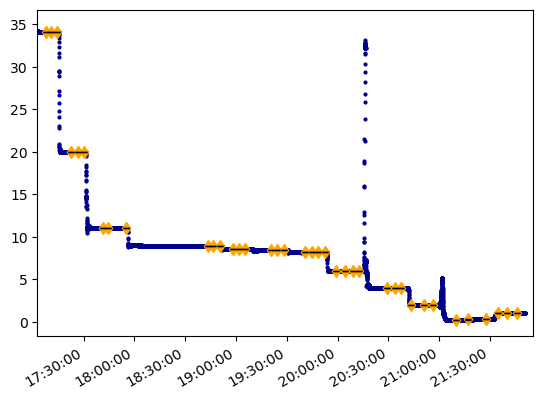

In [13]:
# Merge this into the OG spectal dataframe
merged_data=pd.merge(left=sdata,right=p_medians,how='outer',left_on='filename_x',right_on='filename_x')
# sort the dataframe by date and time
merged_data.sort_values(by='Date and Time',inplace=True)

display(merged_data.head())

plt.plot_date(pdata['Date and Time'],pdata['Pressure / MPa'],'o',markersize=2,color='darkblue',zorder=0)
plt.errorbar(merged_data['Date and Time - offset'],merged_data['median_pressure'], yerr=merged_data['mad_pressure'], fmt='d',color='orange',mfc='orange', ecolor='black', capsize=2,barsabove=True,zorder=1)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.xlim(xmin=pdata['Date and Time'][len(pdata['Date and Time'])-1]-datetime.timedelta(hours=4.8), xmax=pdata['Date and Time'][len(pdata['Date and Time'])-1]+datetime.timedelta(minutes=5))

## Export merged data to excel or clipboard

In [14]:
#Export the updated dataframe to excel
merged_data.to_excel(path+'/'+'merged_dataframe.xlsx')
#Export the updated dataframe to clipboard
merged_data.to_clipboard(excel=True)